In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import euclidean, cityblock

plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv("DSL-StrongPasswordData.csv")
subject = df['subject']
df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1.0,1.0,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,0.2212,0.1043,0.1417,1.1885,1.0468,0.1146,1.6055,1.4909,0.1067,0.7590,0.6523,0.1016,0.2136,0.1120,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1.0,2.0,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,0.1357,0.0449,0.0829,1.1970,1.1141,0.0689,0.7822,0.7133,0.1570,0.7877,0.6307,0.1066,0.1684,0.0618,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1.0,3.0,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,0.1542,0.0721,0.0808,1.0408,0.9600,0.0892,0.6203,0.5311,0.1454,0.7195,0.5741,0.1365,0.2931,0.1566,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1.0,4.0,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,0.2038,0.0998,0.0900,1.0556,0.9656,0.0913,1.2564,1.1651,0.1454,0.7550,0.6096,0.0956,0.1530,0.0574,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1.0,5.0,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,0.1589,0.0686,0.0805,0.8629,0.7824,0.0742,0.8955,0.8213,0.1243,0.7632,0.6389,0.0430,0.1975,0.1545,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


In [8]:
def load_data(file_name, col_to_remove):
    df = pd.read_csv(file_name)

    H_columns  = [col for col in df.columns if col.startswith('H')]
    DD_columns = [col for col in df.columns if col.startswith('DD')]
    UD_columns = [col for col in df.columns if col.startswith('UD')]

    data = {}
    data['total'] = df.drop(columns=col_to_remove)
    data['H']     = df[H_columns]
    data['DD']    = df[DD_columns]
    data['UD']    = df[UD_columns]
    #data['pca3']  = pd.DataFrame(PCA(n_components=3).fit_transform(data['total']))
    data['pca10'] = pd.DataFrame(PCA(n_components=10).fit_transform(data['total']))
    
    return data, df['subject'].values

def calculate_KMeans(data,y):
    X = data['total']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=y)
    n_neighbors = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    parameters = dict(n_neighbors=n_neighbors)
    clf = KNeighborsClassifier()
    grid = GridSearchCV(clf, parameters, cv=5)
    grid.fit(X_train, Y_train)
    results = grid.cv_results_

    Y_pred = grid.predict(X_test)

    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())

    return fpr, tpr, threshold

In [9]:
data,y = load_data("DSL-StrongPasswordData.csv", ['subject', 'sessionIndex', 'rep'])
Y = pd.get_dummies(y).values
fpr2_2, tpr2_2, threshold2_2 = calculate_KMeans(data,y)
eer2_2 = brentq(lambda x : 1. - x - interp1d(fpr2_2, tpr2_2)(x), 0., 1.)

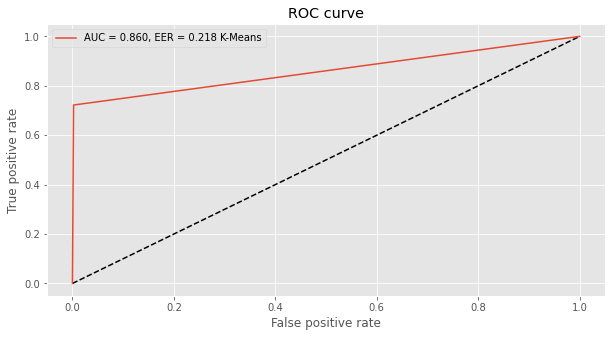

K-Means distance shows error rates  0.21787580694749598


In [11]:
plt.figure(figsize = (10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2_2, tpr2_2, label='AUC = {:.3f}, EER = {:.3f} K-Means'.format(auc(fpr2_2, tpr2_2), eer2_2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("K-Means distance shows error rates ", eer2_2)
